In [39]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import re
import xml.etree.ElementTree as ET
import xmltodict
import collections
import itertools
from scipy import stats
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from ratelimit import limits, sleep_and_retry
from datetime import date
from dateutil.relativedelta import relativedelta
from random import sample
import sys
import gmaps

In [2]:
StateSelected = ['GA']

In [3]:
zipcodes=pd.read_csv('free-zipcode-database-Primary.csv')
zipcodes.head()

,Zipcode,City,State
0,705,AIBONITO,PR
1,610,ANASCO,PR
2,611,ANGELES,PR
3,612,ARECIBO,PR
4,601,ADJUNTAS,PR


In [4]:
gazipcodes= zipcodes[zipcodes.State.isin(StateSelected)]

In [5]:
gazipcodes.count()

Zipcode    973
City       973
State      973
dtype: int64

# Perform API Calls from ATTOM to get Full Address List

In [6]:
FullAddress=[]
Street=[]
CityStateZip=[]
Latitude=[]
Longitude=[]
pd.Series(FullAddress)
pd.Series(Latitude)
pd.Series(Longitude)

Data_set=pd.DataFrame({'FullAddress':pd.Series(FullAddress),'Street':pd.Series(Street),'CityStateZip':pd.Series(CityStateZip),'Latitude':pd.Series(Latitude),'Longitude':pd.Series(Longitude)})
Data_set.head()

,FullAddress,Street,CityStateZip,Latitude,Longitude


In [9]:
params = {'accept': "application/json",
          'apikey': "9d078487e223b1c4d54c3f3a3f628803"} 

url=f"https://search.onboard-apis.com/propertyapi/v1.0.0/property/address?postalcode=postalcode&page=1&pagesize=100"

for index, row in gazipcodes.iterrows():
    postalcode=row['Zipcode']
    url=f"https://search.onboard-apis.com/propertyapi/v1.0.0/property/address?postalcode={postalcode}&page=1&pagesize=1000"
    res = requests.get(url,headers=params)
    data =json.loads(res.text)
    we=data
    try:
        d=pd.DataFrame(data['property'])
        d['FullAddress']=d['address'].apply(lambda a:a['oneLine'])
        d['Street']=d['address'].apply(lambda d:d['line1'])
        d['CityStateZip']=d['address'].apply(lambda d:d['line2'])
        d['Latitude']=d['location'].apply(lambda c:c['latitude'])
        d['Longitude']=d['location'].apply(lambda b:b['longitude'])
        datatoappend=d[['FullAddress','Street','CityStateZip','Latitude','Longitude']]
        Data_set=Data_set.append(datatoappend)
        
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

KeyboardInterrupt: 

In [10]:
Data_set['Zillow format add']=Data_set['Street'].replace(" ", "+",regex=True)
Data_set['Zillow format Zipcity']=Data_set['CityStateZip'].replace(" ", "+",regex=True)
Data_set.head()

,FullAddress,Street,CityStateZip,Latitude,Longitude,Zillow format add,Zillow format Zipcity
0,"2412 MCDANIEL STATION RD SW, CALHOUN, GA 30701",2412 MCDANIEL STATION RD SW,"CALHOUN, GA 30701",34.420701,-84.973725,2412+MCDANIEL+STATION+RD+SW,"CALHOUN,+GA+30701"
1,"2555 MCDANIEL STATION RD SW, CALHOUN, GA 30701",2555 MCDANIEL STATION RD SW,"CALHOUN, GA 30701",34.422063,-84.971725,2555+MCDANIEL+STATION+RD+SW,"CALHOUN,+GA+30701"
2,"1694 MILLER FERRY RD SW # A, CALHOUN, GA 30701",1694 MILLER FERRY RD SW # A,"CALHOUN, GA 30701",34.422212,-84.975806,1694+MILLER+FERRY+RD+SW+#+A,"CALHOUN,+GA+30701"
3,"1694 MILLER FERRY RD SW # A, CALHOUN, GA 30701",1694 MILLER FERRY RD SW # A,"CALHOUN, GA 30701",34.422212,-84.975806,1694+MILLER+FERRY+RD+SW+#+A,"CALHOUN,+GA+30701"
4,"1707 MILLER FERRY RD SW, CALHOUN, GA 30701",1707 MILLER FERRY RD SW,"CALHOUN, GA 30701",34.422410,-84.976152,1707+MILLER+FERRY+RD+SW,"CALHOUN,+GA+30701"


In [11]:
# We have total over 66,000 GA address data

# Randomly select 10,000 data sample

In [12]:
# create random index
# rindex =  np.array(sample(range(len(Data_set)), 10000))

# np.random.shuffle(rindex)

# # get 10,000 random rows from Data_set
# Data_set_random = Data_set.iloc[rindex]

In [13]:
# # split 10,000 dataset into 3 subsets
# data_random1=Data_set_random.iloc[0-3000:]
# data_random2=Data_set_random.iloc[3000-6000:]
# data_random3=Data_set_random.iloc[6000-10000:]

In [14]:
# data_random1.to_csv('data_random1.csv')
# data_random2.to_csv('data_random2.csv')
# data_random3.to_csv('data_random3.csv')

# Feed the address to Zillow API

In [15]:
# Example of getting 10 data from Zillow due to daily limit of 1000 calls
# We actually run 10 times of the following code since our sample size is 10,000
Data_set=Data_set.head(10)

In [16]:
zid = 'X1-ZWz1go72alddzf_8469v'

In [17]:
zpid=[]
zest=[]
addr =[]
city=[]
zipC=[]
type=[]
rooms=[]
sqft=[]
state=[]
lastsoldprice=[]
lastsolddate=[]
year_built=[]
c_value=[]
county=[]
lat =[]
lon =[]
Zindex =[]

for index, row in Data_set.iterrows():
    add=row['Zillow format add']
    statezip=row['Zillow format Zipcity']
    params2=f'{add}&citystatezip={statezip}'
    url2 = f"http://www.zillow.com/webservice/GetDeepSearchResults.htm?zws-id={zid}&address={params2}"
    
    response2 = requests.get(url2, params=params2)
    
    tree=ET.fromstring(response2.content)
    results=tree.findall('./response/results/result')
    
    if len(results)!=0:
        re=results[0] 
        dic=xmltodict.parse(ET.tostring(re))
        try: 
            
             Zid=dic['result'].get('zpid',np.nan)
             zestimate=dic['result']['zestimate']['amount'].get('#text',np.nan)
             strt=dic['result']['address'].get('street',np.nan)
             zip=dic['result']['address'].get('zipcode',np.nan)
             cit=dic['result']['address'].get('city',np.nan)
             price=dic['result'].get('lastSoldPrice',np.nan)
             solddate=dic['result'].get('lastSoldDate',np.nan)
             room=dic['result'].get('bedrooms',np.nan)
             usecode=dic['result'].get('useCode',np.nan)
             sqftt=dic['result'].get('finishedSqFt',np.nan)
             yearbuilt=dic['result'].get('yearBuilt',np.nan)
             contyvalue=dic['result'].get('taxAssessment',np.nan)
             Zindx =dic['result'].get('localRealEstate',np.nan)
             year_built.append(yearbuilt)
             lati=dic['result']['address'].get('latitude',np.nan)
             longi=dic['result']['address'].get('longitude',np.nan)
             lon.append(longi)
             lat.append(lati)
             zest.append(zestimate)
             zpid.append(Zid)
             addr.append(strt)
             zipC.append(zip)
             city.append(cit)
             lastsoldprice.append(price)
             rooms.append(room)
             type.append(usecode)
             sqft.append(sqftt)
             c_value.append(contyvalue)
             lastsolddate.append(solddate)
             Zindex.append(Zindx)
             longi=[]
             lati=[]
             Zindx=[]
             solddate=[]
             zestimate=[]
             Zid=[]
             price=[]
             room=[]
             usecode=[]
             sqftt=[]
             cit=[]
             usecode=[]
             yearbuilt=[]
             contyvalue=[]
             strt=[]
             print(f'got it updating')
             
        except (KeyError, IndexError):
             print(skip)

got it updating
got it updating
got it updating
got it updating
got it updating
got it updating
got it updating
got it updating


In [18]:
d=pd.DataFrame({'Zillow Id':pd.Series(zpid),'Zestimate':pd.Series(zest),'Street':pd.Series(addr),\
                'City':pd.Series(city),'ZipCode':pd.Series(zipC),'lastSold':pd.Series(lastsoldprice),\
                'Bedrooms':pd.Series(rooms),'typeofhome':pd.Series(type),'Squareft':pd.Series(sqft),\
                'YearBuilt':pd.Series(year_built),'CountTax':pd.Series(c_value),\
                'Latitude':pd.Series(lat),'Longitude':pd.Series(lon),'LastSoldDate':pd.Series(lastsolddate),\
                'Z_index':pd.Series(Zindex)})  

In [19]:
df=d.drop_duplicates(['Zillow Id'])
df.head()

,Zillow Id,Zestimate,Street,City,ZipCode,lastSold,Bedrooms,typeofhome,Squareft,YearBuilt,CountTax,Latitude,Longitude,LastSoldDate,Z_index
0,76449907,552170,2412 Mcdaniel Station Rd SW,CALHOUN,30701,NaN,3,SingleFamily,1835,1969,736770.0,34.428137,-84.96223,NaN,"{'region': {'@id': '23912', '@name': 'Calhoun'..."
1,2100336775,58143,2555 Mcdaniel Station Rd SW,Calhoun,30701,"{'@currency': 'USD', '#text': '48000'}",2,Mobile,NaN,1997,NaN,34.424662,-84.968148,09/09/2016,"{'region': {'@id': '23912', '@name': 'Calhoun'..."
2,76449885,111495,1707 Miller Ferry Rd SW,CALHOUN,30701,NaN,2,SingleFamily,1271,1950,105900.0,34.422659,-84.975192,NaN,"{'region': {'@id': '23912', '@name': 'Calhoun'..."
3,76449750,375266,225 Robbins Creek Trl SW,CALHOUN,30701,"{'@currency': 'USD', '#text': '5000'}",4,SingleFamily,4700,1999,331600.0,34.422825,-84.983753,07/11/2005,"{'region': {'@id': '3312', '@name': 'Adairsvil..."
4,76449749,411761,222 Robbins Creek Trl SW,CALHOUN,30701,"{'@currency': 'USD', '#text': '45000'}",6,SingleFamily,5092,2004,415400.0,34.422188,-84.981015,11/02/2012,"{'region': {'@id': '3312', '@name': 'Adairsvil..."


In [20]:
df['LastSold']=df['lastSold'].apply(lambda l: l.get('#text', np.nan) if isinstance(l, dict) else np.nan)
df['Zindex']=df['Z_index'].apply(lambda l: l.get('region', np.nan) if isinstance(l, dict) else np.nan)
df['Z_index']=df['Zindex'].apply(lambda l: l.get('zindexValue', np.nan) if isinstance(l, dict) else np.nan)
df.head()

,Zillow Id,Zestimate,Street,City,ZipCode,lastSold,Bedrooms,typeofhome,Squareft,YearBuilt,CountTax,Latitude,Longitude,LastSoldDate,Z_index,LastSold,Zindex
0,76449907,552170,2412 Mcdaniel Station Rd SW,CALHOUN,30701,NaN,3,SingleFamily,1835,1969,736770.0,34.428137,-84.96223,NaN,"126,700",NaN,"{'@id': '23912', '@name': 'Calhoun', '@type': ..."
1,2100336775,58143,2555 Mcdaniel Station Rd SW,Calhoun,30701,"{'@currency': 'USD', '#text': '48000'}",2,Mobile,NaN,1997,NaN,34.424662,-84.968148,09/09/2016,"126,700",48000,"{'@id': '23912', '@name': 'Calhoun', '@type': ..."
2,76449885,111495,1707 Miller Ferry Rd SW,CALHOUN,30701,NaN,2,SingleFamily,1271,1950,105900.0,34.422659,-84.975192,NaN,"126,700",NaN,"{'@id': '23912', '@name': 'Calhoun', '@type': ..."
3,76449750,375266,225 Robbins Creek Trl SW,CALHOUN,30701,"{'@currency': 'USD', '#text': '5000'}",4,SingleFamily,4700,1999,331600.0,34.422825,-84.983753,07/11/2005,"124,300",5000,"{'@id': '3312', '@name': 'Adairsville', '@type..."
4,76449749,411761,222 Robbins Creek Trl SW,CALHOUN,30701,"{'@currency': 'USD', '#text': '45000'}",6,SingleFamily,5092,2004,415400.0,34.422188,-84.981015,11/02/2012,"124,300",45000,"{'@id': '3312', '@name': 'Adairsville', '@type..."


# Combine data and clean data

In [21]:
# combine data and get 5698 observations



In [22]:
combined_data = pd.read_csv('Combineddata.csv')
combined_data.City=combined_data.City.map(lambda x: x.upper())
combined_data.head()

,Unnamed: 0,Zillow Id,Zestimate,Street,City,ZipCode,lastSold,Bedrooms,typeofhome,Squareft,YearBuilt,CountTax,Latitude,Longitude,LastSoldDate,Z_index,LastSold,Zindex
0,0,93123448,345560.0,256 Buckshot Ln,TIGER,30576.0,"OrderedDict([('@currency', 'USD'), ('#text', '...",4.0,SingleFamily,4200.0,2001.0,290723.0,34.822040,-83.446890,10/1/2002,"165,300",285000.0,"OrderedDict([('@id', '14139'), ('@name', 'Tige..."
1,1,82452558,155747.0,65 Sunrise Dr,GRANTVILLE,30220.0,"OrderedDict([('@currency', 'USD'), ('#text', '...",4.0,SingleFamily,1496.0,2006.0,118800.0,33.229140,-84.825290,11/19/2010,"113,700",54000.0,"OrderedDict([('@id', '45530'), ('@name', 'Gran..."
2,2,111793656,58879.0,2085 Jackson Rd,ROBERTA,31078.0,"OrderedDict([('@currency', 'USD'), ('#text', '...",3.0,Mobile,1152.0,1995.0,57838.0,32.692290,-83.950920,2/12/2018,NaN,56750.0,"OrderedDict([('@id', '18858'), ('@name', 'Knox..."
3,3,2139757076,150542.0,6301 Chief O F Love Rd B-5,SAVANNAH,31419.0,NaN,2.0,Condominium,1300.0,2008.0,NaN,31.993879,-81.281182,NaN,NaN,NaN,"OrderedDict([('@id', '763636'), ('@name', 'The..."
4,4,221933009,233334.0,1900 Bell Ln,BRASELTON,30517.0,"OrderedDict([('@currency', 'USD'), ('#text', '...",0.0,SingleFamily,2653.0,2006.0,192468.0,34.108109,-83.790392,5/26/2017,"275,900",210999.0,"OrderedDict([('@id', '41949'), ('@name', 'Bras..."


In [23]:
combined_data_selected=combined_data[['Zestimate', 'City','ZipCode','Street','Bedrooms', 'LastSoldDate','typeofhome', 
                                      'Squareft', 'YearBuilt', 'CountTax','LastSold','Z_index']]

In [24]:
combined_data_selected.head()

,Zestimate,City,ZipCode,Street,Bedrooms,LastSoldDate,typeofhome,Squareft,YearBuilt,CountTax,LastSold,Z_index
0,345560.0,TIGER,30576.0,256 Buckshot Ln,4.0,10/1/2002,SingleFamily,4200.0,2001.0,290723.0,285000.0,"165,300"
1,155747.0,GRANTVILLE,30220.0,65 Sunrise Dr,4.0,11/19/2010,SingleFamily,1496.0,2006.0,118800.0,54000.0,"113,700"
2,58879.0,ROBERTA,31078.0,2085 Jackson Rd,3.0,2/12/2018,Mobile,1152.0,1995.0,57838.0,56750.0,NaN
3,150542.0,SAVANNAH,31419.0,6301 Chief O F Love Rd B-5,2.0,NaN,Condominium,1300.0,2008.0,NaN,NaN,NaN
4,233334.0,BRASELTON,30517.0,1900 Bell Ln,0.0,5/26/2017,SingleFamily,2653.0,2006.0,192468.0,210999.0,"275,900"


# compare zestimate and lastsold, find most investable areas

In [26]:
df2=combined_data_selected.dropna(how='any')

In [28]:
difference=(df2['Zestimate']-df2['LastSold'])/df2['LastSold']
df2['Difference']=difference
df2

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Zestimate,City,ZipCode,Street,Bedrooms,LastSoldDate,typeofhome,Squareft,YearBuilt,CountTax,LastSold,Z_index,Difference
0,345560.0,TIGER,30576.0,256 Buckshot Ln,4.0,10/1/2002,SingleFamily,4200.0,2001.0,290723.0,285000.0,"165,300",0.212491
1,155747.0,GRANTVILLE,30220.0,65 Sunrise Dr,4.0,11/19/2010,SingleFamily,1496.0,2006.0,118800.0,54000.0,"113,700",1.884204
4,233334.0,BRASELTON,30517.0,1900 Bell Ln,0.0,5/26/2017,SingleFamily,2653.0,2006.0,192468.0,210999.0,"275,900",0.105854
11,57489.0,ALBANY,31705.0,4860 Pinto Dr,3.0,2/23/2016,SingleFamily,1375.0,1973.0,62000.0,58000.0,"82,500",-0.008810
16,211563.0,NORCROSS,30093.0,765 Kenneth Ln,3.0,2/2/1999,SingleFamily,2327.0,1970.0,171200.0,132000.0,"149,300",0.602750
24,140659.0,TIFTON,31793.0,1703 Regent Rd W,3.0,1/24/2011,SingleFamily,1892.0,1977.0,132983.0,120000.0,"123,800",0.172158
26,105879.0,NORCROSS,30092.0,3351 September Morn,1.0,5/10/2004,Condominium,1152.0,1983.0,74500.0,74900.0,"327,900",0.413605
27,338094.0,ROME,30165.0,119 Featherston Rd SW,4.0,10/28/2011,SingleFamily,2932.0,1986.0,318112.0,286900.0,"116,800",0.178438
32,533416.0,HAMILTON,31811.0,133 Hall Dr,4.0,5/20/1998,SingleFamily,4157.0,1980.0,297752.0,239900.0,"192,200",1.223493
33,264707.0,DECATUR,30030.0,2606 Charlesgate Ave,2.0,9/5/2016,SingleFamily,974.0,1950.0,189600.0,205000.0,"113,900",0.291254


In [29]:
df2['LastSoldDate'].astype(date)
df2['YearSold']= pd.to_datetime(df['LastSoldDate']).dt.to_period('y')
df2['YearBuilt']=pd.to_datetime(df['YearBuilt']).dt.to_period('y')

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [30]:
# compare difference among houses sold within 10 yeas

df2['lalala']=date.today()-relativedelta(years=+10)
df2['lalala']=pd.to_datetime(df2['lalala']).dt.to_period('y')
df2

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Zestimate,City,ZipCode,Street,Bedrooms,LastSoldDate,typeofhome,Squareft,YearBuilt,CountTax,LastSold,Z_index,Difference,YearSold,lalala
0,345560.0,TIGER,30576.0,256 Buckshot Ln,4.0,10/1/2002,SingleFamily,4200.0,1969,290723.0,285000.0,"165,300",0.212491,NaT,2008
1,155747.0,GRANTVILLE,30220.0,65 Sunrise Dr,4.0,11/19/2010,SingleFamily,1496.0,1997,118800.0,54000.0,"113,700",1.884204,2016,2008
4,233334.0,BRASELTON,30517.0,1900 Bell Ln,0.0,5/26/2017,SingleFamily,2653.0,2004,192468.0,210999.0,"275,900",0.105854,2012,2008
11,57489.0,ALBANY,31705.0,4860 Pinto Dr,3.0,2/23/2016,SingleFamily,1375.0,NaT,62000.0,58000.0,"82,500",-0.008810,NaT,2008
16,211563.0,NORCROSS,30093.0,765 Kenneth Ln,3.0,2/2/1999,SingleFamily,2327.0,NaT,171200.0,132000.0,"149,300",0.602750,NaT,2008
24,140659.0,TIFTON,31793.0,1703 Regent Rd W,3.0,1/24/2011,SingleFamily,1892.0,NaT,132983.0,120000.0,"123,800",0.172158,NaT,2008
26,105879.0,NORCROSS,30092.0,3351 September Morn,1.0,5/10/2004,Condominium,1152.0,NaT,74500.0,74900.0,"327,900",0.413605,NaT,2008
27,338094.0,ROME,30165.0,119 Featherston Rd SW,4.0,10/28/2011,SingleFamily,2932.0,NaT,318112.0,286900.0,"116,800",0.178438,NaT,2008
32,533416.0,HAMILTON,31811.0,133 Hall Dr,4.0,5/20/1998,SingleFamily,4157.0,NaT,297752.0,239900.0,"192,200",1.223493,NaT,2008
33,264707.0,DECATUR,30030.0,2606 Charlesgate Ave,2.0,9/5/2016,SingleFamily,974.0,NaT,189600.0,205000.0,"113,900",0.291254,NaT,2008


In [ ]:
df2=df2[df2['LastSold']>30000]
df2=df2[df2['YearSold']>df2['YearBuilt']]
df2=df2[df2['YearSold']>df2['lalala']]
df2.sort_values('Difference',ascending=False)

In [ ]:
mean_diff=df2.groupby(['City','ZipCode'])['Difference'].mean().reset_index()
mean_diff=mean_diff.rename(columns={'Difference':'Diff_mean'})
mean_diff = mean_diff.sort_values(['Diff_mean','City','ZipCode'], ascending=[False,True,True])
mean_diff.head(10)

# Multivariate Regression:

In [ ]:
df_zestimate=combined_data[['Zestimate', 'Bedrooms','YearBuilt','Squareft']]
df_lastsold=combined_data[['LastSold', 'Bedrooms','YearBuilt','Squareft']]

df_zestimate=df_zestimate.dropna(how='any')
df_lastsold=df_lastsold.dropna(how='any')

df_zestimate=df_zestimate[df_zestimate['Zestimate']<500000]
df_zestimate=df_zestimate[df_zestimate['Squareft']<10000]

df_lastsold=df_lastsold[df_lastsold['LastSold']<500000]
df_lastsold=df_lastsold[df_lastsold['Squareft']<10000]

In [ ]:
X = df_zestimate[['Squareft', 'Bedrooms', 'YearBuilt']]
Y = df_zestimate['Zestimate']

X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

In [ ]:
X = df_lastsold[['Squareft', 'Bedrooms', 'YearBuilt']]
Y = df_lastsold['LastSold']

X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

In [ ]:
X = df_zestimate[['Squareft', 'Bedrooms']]
Y = df_zestimate['Zestimate']

X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

In [ ]:
X = df_lastsold[['Squareft', 'Bedrooms']]
Y = df_lastsold['LastSold']

X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

In [ ]:
X = df_zestimate[['Squareft', 'YearBuilt']]
Y = df_zestimate['Zestimate']
X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

In [ ]:
X = df_lastsold[['Squareft', 'YearBuilt']]
Y = df_lastsold['LastSold']
X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

In [ ]:
X = df_zestimate[['Bedrooms', 'YearBuilt']]
Y = df_zestimate['Zestimate']
X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

In [ ]:
X = df_lastsold[['Bedrooms', 'YearBuilt']]
Y = df_lastsold['LastSold']
X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

In [ ]:
X = df_zestimate['Squareft']
Y = df_zestimate['Zestimate']
X1 = sm.add_constant(X)
reg = sm.OLS(Y.astype(float), X1.astype(float)).fit()

reg.summary()

# House Price Index trend

In [ ]:
file=pd.read_csv('ATXRNSA.csv')
file.head()
file.groupby(['DATE'])

In [ ]:
file['Month-year']=pd.to_datetime(file['DATE']).dt.to_period('y')
file.head()

In [ ]:
plt.figure(figsize=(40,3))
x_axis = list(range(0,len(file['Month-year'])))
plt.plot(file['ATXRNSA'])
plt.xticks(x_axis,file['Month-year'],rotation="vertical")
plt.xlabel("Month")
plt.ylabel("House Price Index")

plt.show()

# Type of homes

In [32]:
Hometype=combined_data.groupby(['typeofhome'])['Zillow Id'].count()
Homes=pd.DataFrame({'type':Hometype}).reset_index()
Homes

,typeofhome,type
0,Apartment,7
1,Condominium,145
2,Duplex,20
3,Miscellaneous,4
4,Mobile,670
5,MultiFamily2To4,21
6,MultiFamily5Plus,2
7,SingleFamily,4638
8,Townhouse,52
9,Triplex,1


In [ ]:
Homes["typeofhome"] = Homes["typeofhome"].replace({"Unknown": "Other", "Triplex": "Other", 
                                                   "Miscellaneous": "Other", "MultiFamily2To4": "Other",
                                                   "MultiFamily5Plus": "Other", "Townhouse": "Condominium",
                                                   "VacantResidentialLand": "Other", "Apartment": "Other",
                                                  "Duplex": "Other"})

In [33]:
Home2 = Homes.groupby("typeofhome")['type'].sum()
Home2

typeofhome
Apartment                   7
Condominium               145
Duplex                     20
Miscellaneous               4
Mobile                    670
MultiFamily2To4            21
MultiFamily5Plus            2
SingleFamily             4638
Townhouse                  52
Triplex                     1
Unknown                    10
VacantResidentialLand     128
Name: type, dtype: int64

ValueError: 'explode' must be of length 'x'

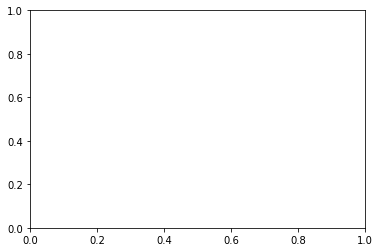

In [34]:
#Build Pie Chart
type_city = Home2.index
colors=["lightcoral","lightskyblue","gold", "lightgreen", "pink"]
explode=[0,0,0,0.1]
plt.pie(Home2,explode=explode,labels=type_city,colors=colors,autopct="%1.1f%%",shadow=True,wedgeprops = {'linewidth': .2, 'edgecolor': 'black'},startangle=0)
plt.title('Homes By Type')
plt.show()
# plt.savefig("Homes_Type.png")

# Heat map


In [36]:
comb = combined_data[['Latitude', 'Longitude','Zestimate', 'City', 'Squareft', 'typeofhome']]

comb=comb[comb['Zestimate']<500000]
comb=comb[comb['Squareft']<10000]

comb.head()

,Latitude,Longitude,Zestimate,City,Squareft,typeofhome
0,34.822040,-83.446890,345560.0,TIGER,4200.0,SingleFamily
1,33.229140,-84.825290,155747.0,GRANTVILLE,1496.0,SingleFamily
2,32.692290,-83.950920,58879.0,ROBERTA,1152.0,Mobile
3,31.993879,-81.281182,150542.0,SAVANNAH,1300.0,Condominium
4,34.108109,-83.790392,233334.0,BRASELTON,2653.0,SingleFamily


In [37]:
comb1 = comb.dropna(how='any')

In [40]:
locations = comb1[['Latitude', 'Longitude']].astype(float)
weights = comb1['Zestimate']
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='420px'))